In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import matplotlib.lines as lines

#import seaborn as sns
#sns.set(style='ticks')

params = {'legend.fontsize': 'x-large',
         'figure.figsize': (15,5),
         'axes.labelsize': 'x-large',
         'axes.titlesize': 'x-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large'}
plt.rcParams.update(params)
%matplotlib inline

pd.options.mode.chained_assignment = None

In [5]:
#open the csv file for miles
filename = 'MiniMiles.csv'

#get the data
mdata = pd.read_csv(filename,skiprows=0)

###Convert Datetime to format
mdata['dtime'] = pd.to_datetime(mdata.dtime,format='%Y-%m-%d %H:%M:%S')
mdata['miles_int'] = 0

nentries = len(mdata)
Miles0 = mdata.miles.min()
for i in range(1,nentries):
    mdata.miles_int.loc[i] = mdata.miles.loc[i]-mdata.miles.loc[i-1]

#mdata['mymiles'] = mdata.miles -mdata.miles[0]
#mdata['dTime'] = mdata.Data + ' ' 

### get the gas data
gfilename = 'GasRefills.csv'

gdata = pd.read_csv(gfilename)
gdata['gtime'] = pd.to_datetime(gdata.gtime,format='%Y-%m-%d %H:%M:%S')

def add_miles(month,day,year,hour,minute, miles):
    newdate = datetime(year, month, day, hour, minute)
    nentries = len(mdata)
    diff = miles - mdata.miles.loc[nentries-1]
    if miles < Miles0:
        print("less miles thatn the initial miles (%d), not adding entry" %Miles0)
        return;
    if diff <= 0:
        print("same or lower milege (%d) as previous entry: %d, not adding point" % (miles,mdata.miles.loc[nentries-1]))
        return;
    
    
    print ('Added entry %s, %d' % (newdate, miles))
    mdata.loc[nentries] =[pd.to_datetime(newdate),miles,diff]
    return;

def add_gas(month,day,year, gallons, price):
    newdate = datetime(year, month, day, 0, 0)
    nentries = len(gdata)
        
    gdata.loc[nentries] =[pd.to_datetime(newdate),gallons, price]
    return;

def save_miles():
    mdata.to_csv('MiniMiles.csv',sep=',',encoding='utf-8', index=False,columns=['dtime','miles'])
    return;

def save_gas():
    gdata.to_csv('GasRefills.csv',sep=',',encoding='utf-8', index=False,columns=['gtime','gallons','price'])
    return;

# Add miles or gas data

In [7]:
#add_miles(month, day, year, hour, minutes, miles)
#add_miles(12,21,2017,20,15,4433)
mdata.tail()

,dtime,miles,miles_int
4,2017-12-20 19:30:00,4358,3
5,2017-12-21 08:44:00,4373,15
6,2017-12-21 14:45:00,4389,16
7,2017-12-21 17:15:00,4411,22
8,2017-12-21 20:15:00,4433,22


In [77]:
#add_gas(month, day, year,hour, minutes, gallons, price)
add_gas(12,18,2017,10,0)

In [8]:
gdata.tail()

,gtime,gallons,price
0,2017-12-18,10,0


## Save the csv data file

In [9]:
save_miles()

In [95]:
save_gas()

# Process the data

Resample the data by day 'D', get the total number of miles driven per day, and cumulative miles driven.

In [10]:
#Get the Series data with time as an index
dt1 = pd.Series(mdata.miles_int.tolist(), index=mdata.dtime)
dt2 = pd.Series(mdata.miles.tolist(), index=mdata.dtime)

#resample the data by day, later it can be by week, or business day
max_m = dt2.resample('D').max();
mpday = dt1.resample('D').sum();

#merge the series into a dataframe
mpd1 = pd.DataFrame(data=mpday.values,columns=['mpd'])
mpd2 = pd.DataFrame(data=mpday.index,columns=['dtime'])
max1 = pd.DataFrame(data=max_m.values,columns=['max_miles'])
mpdt = pd.merge(mpd2,mpd1,left_index=True, right_index=True);

mpd = mpdt.merge(max1,left_index=True,right_index=True)

#gas data
NGas = len(gdata)

# Plot the miles vs time

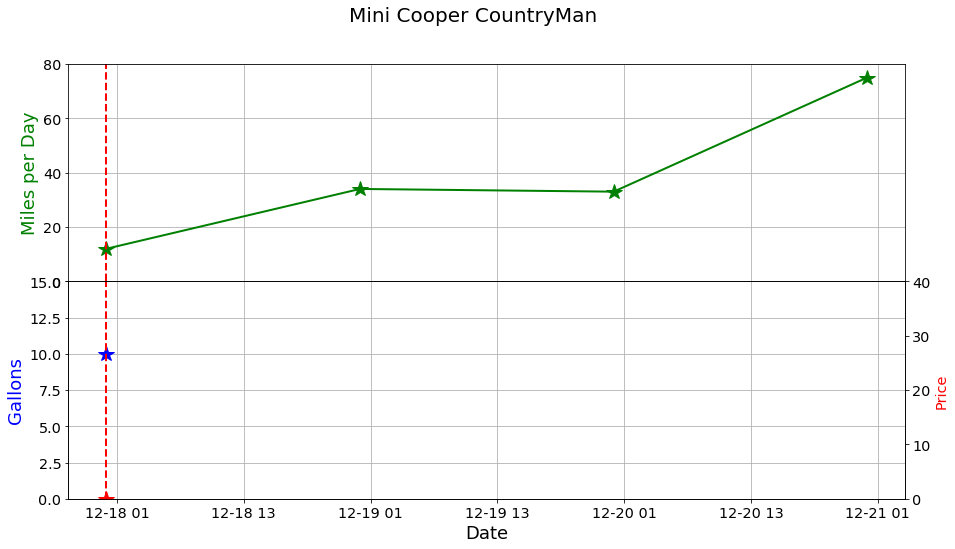

In [17]:
fig, ax1 = plt.subplots(2,sharex=True,figsize=(15,8))
#ax2 = ax1.twinx()
fig.suptitle('Mini Cooper CountryMan',fontsize=20)
ax1[0].plot(mpd.dtime, mpd.mpd,'g*-',linewidth=2,ms=16 )
#ax1[1].plot(mpd.dtime, mpd.max_miles-Miles0,'b*-',linewidth=2,ms=16)

ax1[1].plot(gdata.gtime, gdata.gallons,'b*-',linewidth=2,ms=16)
ax2 = ax1[1].twinx()
ax2.plot(gdata.gtime, gdata.price, 'r*-',linewidth=2,ms=16)
ax2.set_ylabel('Price', color='r')
#
#set the titles
#ax1.format_xdata = mpd.dtime.DateFormatter('%Y-%m')
#ax1[0].format_xdata = mpd.dtime.DateFormatter('%Y-%m-%d')
ax1[0].set_ylabel('Miles per Day', color ='g',fontsize=18)
ax1[1].set_ylabel('Gallons', color ='b',fontsize=18)
ax1[1].set_xlabel('Date',fontsize=18)
ax1[0].grid(True)
ax1[1].grid(True)

ax1[0].set_ylim(0,80)
ax1[1].set_ylim(0,15)
ax2.set_ylim(0,40)
fig.subplots_adjust(hspace=0)


##
#line = lines.Line2D([gdata.gtime[0], 15], [gdata.gtime[0], 35], lw=2, color='red', axes=ax1[0])
#ax1[0].add_line(line)
#l1=plt.axhline(50,color='red',ls='-')
for i in range(NGas):
    ax1[0].axvline(gdata.gtime[i], color='r', linestyle='--', lw=2)
    ax1[1].axvline(gdata.gtime[i], color='r', linestyle='--', lw=2)
#l2=plt.axvline(pd.to_datetime(gdata.gtime[0]),color='red',ls='-')
plt.show()

1

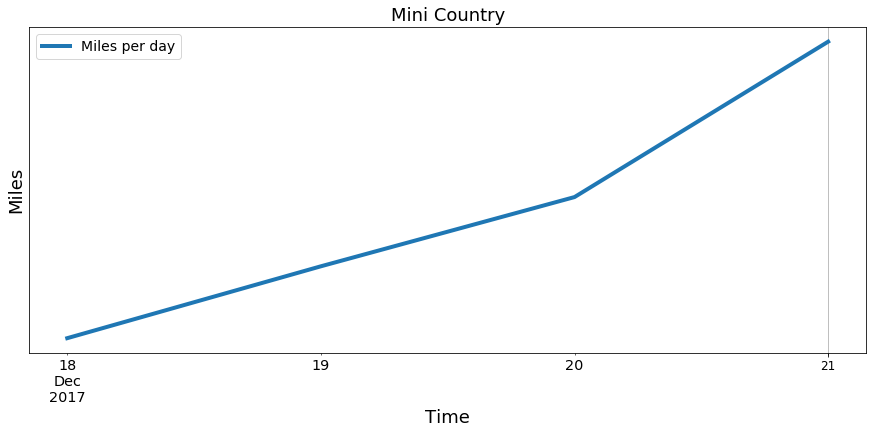

In [19]:
fig = plt.figure(2)
mpd.plot(x='dtime',y='max_miles',figsize=(15,6),grid=True,kind='line',
         label='Miles per day',linewidth=4,title='Miles per day')
plt.ylabel('Miles',fontsize=18)
plt.xlabel('Time',fontsize = 18)
plt.semilogy()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
#plt.savefig('Thermal_Profile//Temperature_1.png')
plt.title('Mini Country',fontsize=18)
len(gdata)#gdata.gtime

In [80]:
#Plot miles per trip
#gdata.gtime[0]
#fig = plt.figure(1)
#mdata[mdata.miles_int >0].plot(x='dtime',y='miles_int',figsize=(15,10),grid=True,label='Miles per trip')

In [15]:
range(0,NGas)

range(0, 1)